# Modelli di regressione consumi Trentino

In questa sezione discuteremo la possibiltà di creare modelli per prevedere la potenza media consumata nella provincia del Trentino durante due 
diverse fascie orarie: giorno 8-19, e sera 19-24.

## Analisi esplorativa dei dati e delle features prese in esame

Il nostro approccio si basa sull'utilizzo dei dati relativi alla giornata precedente. Vogliamo capire quali sono le features che incidono di più nella previsione della potenza media consumata: ci aspettiamo infatti che alcuni dati come l'energia consumata il giorno precedente siano molto più importanti di altri.

In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV , ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

Per prima cosa carichiamo i dataframe creati durante l'EDA dividendo le fasce orarie giorno e sera definite in precedenza.

In [280]:
df_reg=pd.read_csv(r"D:\03_TURO\UNI\TRIENNALE\III_ANNO\Data_Science\Project\Data_reg\trentino_dataset_reg.csv")
df_day=df_reg[df_reg["fascia_giorno"]==1]
df_night=df_reg[df_reg["fascia_giorno"]==0]


Come prima cosa eseguiamo una pulizia manuale: ci sono delle features che sono sicuramente poco rilevanti nel nostro progetto e che si possono togliere. Tra queste troviamo ad esempio il giorno del mese e l'ID della cella. Chiaramente avendo diviso il df in giorno e notte eliminiamo anche 'fascia_giorno'. Discuteremo poi la possibilità di scartare altre features per trovare potenzialmente un algoritmo di previsione migliore.

In [282]:
features_drop = [
    'cellId',
    'day',
    'fascia_giorno',
]

In quest'altro array invece ridefiniamo le features che utilizziamo nel nostro modello per rendere la lettura più chiara.

In [284]:
features_0 ={ 
 'UBIC_CELL':'UBIC_CELL',
 'n_linee': 'N_LINEE',
 'energy':'ENERGIA',
 'tweet_count':'tweet_count',
 'precip_mm': 'precip_mm',  
 'temp_min':'T_MIN',
 'temp_max':'T_MAX',
 'temp_mean':'T_MEAN',
 'NOV':'NOV',
 'DEC':'DEC',
 'LU':'LUN',
 'MA':'MAR',
 'ME':'MER',
 'GI':'GIO',
 'VE':'VEN',
 'SA':'SAB',
 'DO':'DOM' ,
 'TargetReg':'Target'  
}

Data frame fascia giorno originale:

In [286]:
df_day

,cellId,day,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,...,NOV,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg
0,155,1,1,4,1,0.072206,9.3,18.9,15.384091,0,...,1,0,0,0,0,0,1,0,0,0.128870
2,155,2,1,4,1,0.128870,12.3,15.9,13.897727,0,...,1,0,0,0,0,0,0,1,0,0.102435
4,155,3,1,4,1,0.102435,12.2,19.2,15.213636,0,...,1,0,0,0,0,0,0,0,1,0.178414
6,155,4,1,4,1,0.178414,8.6,10.9,9.402273,0,...,1,0,1,0,0,0,0,0,0,0.108142
8,155,5,1,4,1,0.108142,8.2,16.6,13.029545,0,...,1,0,0,1,0,0,0,0,0,0.121344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237912,11099,26,1,3,1,0.329076,0.1,0.8,0.436364,0,...,0,1,0,0,0,1,0,0,0,0.298320
237914,11099,27,1,3,1,0.298320,-2.9,2.0,-0.500000,0,...,0,1,0,0,0,0,1,0,0,0.317222
237916,11099,28,1,3,1,0.317222,-3.7,2.8,-0.904545,0,...,0,1,0,0,0,0,0,1,0,0.331215
237918,11099,29,1,3,1,0.331215,-0.3,2.2,0.713953,0,...,0,1,0,0,0,0,0,0,1,0.324854


Definiamo una funzione di pre-processing che divide i due dataframe originali, fascia giorno e notte, in 3 data frame (X) di training (60%), valid (20%) e test (20%). In più salviamo il vero target, ossia la potenza del giorno successivo nei data set (Y) corrispondenti di train,valid e test. Notare che il 31 dicembre essendo ultimo giorno del mese è stato eliminato già in EDA perchè non abbiamo dati con cui confrontare le nostre previsioni

In [288]:
def pre_processing(df_day,df_night,features_drop,features):
            """
        funzione che compie azioni di preprocessing dividendo il df in train/valid/test e target energetico
        funzione che prende in INPUT
        -> df_day: dataframe fascia oraria giorno
        -> df_night: dataframe fascia oraria notte
        -> features_drop sono le features che eliminiamo dai dataframe
        -> features sono le features dei nuovi dataframe
        OUTPUT
        -> X_train/valid/test_day dataframe degli insiemi di train/validazione/test di giorno senza la previsione del giorno successivo
        -> X_train/valid/test_night dataframe degli insiemi di train/validazione/test di notte senza la previsione del giorno successivo
        -> Y_train/valid/test_day dataframe degli insiemi di train/validazione/test di giorno con solo la previsione del giorno successivo
        -> Y_train/valid/test_night dataframe degli insiemi di train/validazione/test di notte con solo la previsione del giorno successivo
        -> df_day_0 nuovo dataframe con solo le features considerate della fascia diurna
        -> df_nught_0 nuovo dataframe con solo le features considerate della fascia serale
        """
            df_day_0=df_day.drop(columns=features_drop)
            df_day_0.rename(columns=features, inplace=True)
            df_night_0=df_night.drop(columns=features_drop)
            df_night_0.rename(columns=features, inplace=True)

            X_train_day, other = train_test_split(df_day_0, test_size=0.4, random_state=1)
            X_valid_day , X_test_day=train_test_split(other, test_size=0.5, random_state=1)
            
            X_train_night, other = train_test_split(df_night_0, test_size=0.4, random_state=1)
            X_valid_night , X_test_night=train_test_split(other, test_size=0.5, random_state=1)
            
            
            Y_train_day=X_train_day['Target']
            Y_valid_day=X_valid_day['Target']
            Y_test_day=X_test_day['Target']
            
            Y_train_night=X_train_night['Target']
            Y_valid_night=X_valid_night['Target']
            Y_test_night=X_test_night['Target']
            
            X_train_day.drop(['Target'], axis=1,inplace=True)
            X_train_night.drop(['Target'], axis=1,inplace=True)
            X_valid_day.drop(['Target'], axis=1,inplace=True)
            X_valid_night.drop(['Target'], axis=1,inplace=True)
            X_test_day.drop(['Target'], axis=1,inplace=True)
            X_test_night.drop(['Target'], axis=1,inplace=True)
            
            df_day_0.drop(['Target'], axis=1,inplace=True)
            df_night_0.drop(['Target'], axis=1,inplace=True)

          
        
            return (X_train_day, X_valid_day, X_test_day,
            Y_train_day, Y_valid_day, Y_test_day,
            X_train_night, X_valid_night, X_test_night,
            Y_train_night, Y_valid_night, Y_test_night,df_day_0,df_night_0)
           

In [289]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_0,df_night_0) = pre_processing(df_day, df_night, features_drop, features_0)

Data set aggiornato con le features prese in esame:

In [291]:
X_train_day

,UBIC_CELL,N_LINEE,ENERGIA,T_MIN,T_MAX,T_MEAN,tweet_count,precip_mm,NOV,DEC,LUN,MAR,MER,GIO,VEN,SAB,DOM
162068,4,1,0.030685,0.5,7.4,4.356818,0,0.0,0,1,0,0,1,0,0,0,0
11954,25,1,0.308270,-0.3,7.9,3.931818,0,0.0,0,1,0,0,0,0,0,0,1
76864,6,1,0.046096,-2.7,8.1,2.822727,0,0.0,0,1,0,1,0,0,0,0,0
118080,267,1,4.983216,11.2,15.7,13.329545,1,0.0,1,0,0,0,0,0,1,0,0
57402,18,1,-0.691476,0.9,5.4,3.479545,0,0.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100114,48,1,0.303426,3.0,7.3,6.034091,0,0.0,1,0,1,0,0,0,0,0,0
196094,33,1,1.089900,-8.1,-3.0,-4.770455,0,0.0,1,0,0,0,1,0,0,0,0
10384,48,1,0.632924,1.7,9.5,5.581818,0,0.0,0,1,0,1,0,0,0,0,0
155416,4,1,0.252407,3.7,14.0,9.675000,0,0.0,1,0,0,1,0,0,0,0,0


In [292]:
features = tuple(X_test_day.columns)

Queste sono le nostre FEATURES 

In [294]:
features

('UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'T_MEAN',
 'tweet_count',
 'precip_mm',
 'NOV',
 'DEC',
 'LUN',
 'MAR',
 'MER',
 'GIO',
 'VEN',
 'SAB',
 'DOM')

A questo punto riscaliamo i dati

In [296]:
scaler = StandardScaler()

In [297]:
scaler.fit(df_day_0)
X_train_day=scaler.transform(X_train_day)
X_valid_day=scaler.transform(X_valid_day)
X_test_day=scaler.transform(X_test_day)

X_train_night=scaler.transform(X_train_night)
X_valid_night=scaler.transform(X_valid_night)
X_test_night=scaler.transform(X_test_night)

Proviamo a plottare una heat map per vedere quali sono i dati più correlati tra loro e se possiamo fare alcune considerazioni iniziali:

<Axes: >

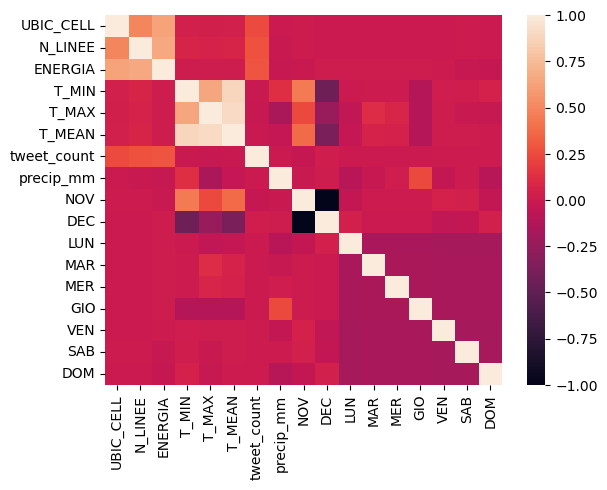

In [299]:
sns.heatmap(df_day_0.corr(method='pearson'))

Dalla heatmap osserviamo che i dati più correlati tra loro sono essenzialmente il numero di ubicazioni per cella, il numero di linea e l'energia prodotta in tale cella. Ciò è plausibilmente sensato dato che più abitazioni ci sono in una cella, più energia viene consumata e più linee saranno presenti per trasportare tale energia. Novembre e dicembre sono completamente anticorrelati dato che quando uno è zero l'altro è uno. Le temperature sono correlate tra loro e anticorrelate ai mesi di novembre e dicembre perchè più andiamo avanti con i mesi e più le temperature si abbassano avvicinandoci all'inverno.

## PRIMO MODELLO DI PREVISIONE CONSUMO ENERGETICO

Per prima cosa proviamo ad utilizzare una regressione lineare. Separiamo sempre il caso giorno e notte.


In [303]:
lin_reg_day= LinearRegression()
lin_reg_night= LinearRegression()

Definiamo una funzione per stampare gli errori

In [305]:
def print_errors(model,x_train, y_train, x_valid, y_valid):
    score_train = model.score(x_train,y_train)
    score_valid = model.score(x_valid,y_valid)

    E_train = mean_squared_error(model.predict(x_train), y_train)
    E_valid = mean_squared_error(model.predict(x_valid), y_valid)
    print(f"r^2_train {score_train} - r^2_valid {score_valid}")
    print(f"Err_train {E_train} - Err_valid {E_valid}")

Facciamo il fit sul train e score sul valid :

In [307]:
lin_reg_day.fit(X_train_day,Y_train_day)
lin_reg_night.fit(X_train_night,Y_train_night)

LinearRegression()

In [308]:
print('Modello lineare giorno:')
print_errors(lin_reg_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello lineare notte:')
print_errors(lin_reg_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello lineare giorno:
r^2_train 0.9162944601695882 - r^2_valid 0.9346704602866092
Err_train 10.895629859187391 - Err_valid 8.943844429859736
Modello lineare notte:
r^2_train 0.9408533725260337 - r^2_valid 0.9434112227348908
Err_train 5.216445734477333 - Err_valid 5.147786083393701


Osserviamo che i modelli lineari sembrano fittare abbastanza bene i dati nell'insieme di valid anche se possiamo fare certamente meglio. Notiamo poi
che il fit eseguito sui dati di notte è più preciso rispetto ai dati della fascia oraria giornaliera. Probabilmente ciò accade perchè la fascia oraria notturna è più corta, e di notte i consumi sono in media più stabili con una varianza minore rispetto alla fascia giornaliera.

Proviamo ad utilizzare il modello Ridge e a cercare il parametro ideale. Quello che fa RidgeCV è che fa lo stesso modello Ridge ma sceglie automaticamente il miglior 𝛼 usando la cross-validation. Scegliamo un array di valori per 𝛼

In [311]:
array= np.logspace(-4,0,num=20)

In [312]:
r_cv_day_0 = RidgeCV(alphas= array, cv=10)
r_cv_night_0 = RidgeCV(alphas= array, cv=10)

Usiamo una 10-fold cross-validation per valutare quale valore di 𝛼 il modello è migliore

In [314]:
r_cv_day_0.fit(X_train_day, Y_train_day)
r_cv_night_0.fit(X_train_night, Y_train_night)
print('RidgeCV_0 giorno:')
print_errors(r_cv_day_0,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV_0 notte:')
print_errors(r_cv_night_0,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV_0 giorno:
r^2_train 0.916294464571341 - r^2_valid 0.9346706373812365
Err_train 10.89562928622805 - Err_valid 8.943820184980572
RidgeCV_0 notte:
r^2_train 0.9408533714958881 - r^2_valid 0.9434120824866418
Err_train 5.216445825331182 - Err_valid 5.147707873220007


Notiamo che la presenza del regolarizzatore non ha modificato per nulla i risultati del modello

Guardiamo quali sono i parametri migliori scelti dal RidgeCV durante la cv:

In [317]:
r_cv_day_0.alpha_

1.0

In [318]:
r_cv_night_0.alpha_

1.0

Vediamo adesso quali sono le feature più significative per i due modelli considerati

Text(0.5, 1.0, 'Pesi r_cv_0 giorno')

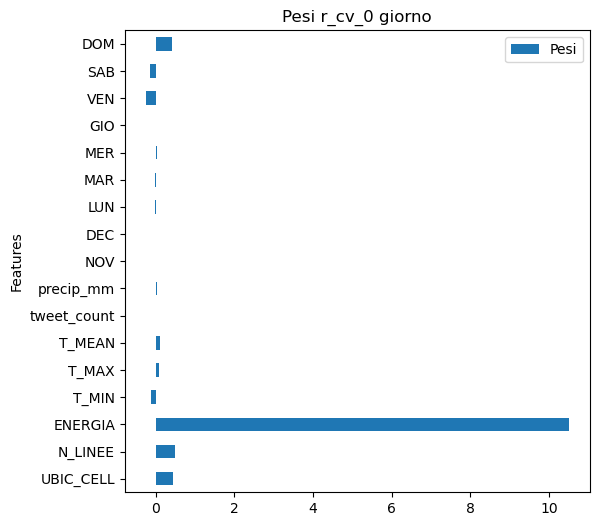

In [320]:
df_w = pd.DataFrame({'features':features, 'Pesi': r_cv_day_0.coef_})
ax = df_w.plot.barh(y='Pesi', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv_0 giorno')


Text(0.5, 1.0, 'Pesi r_cv_0 sera')

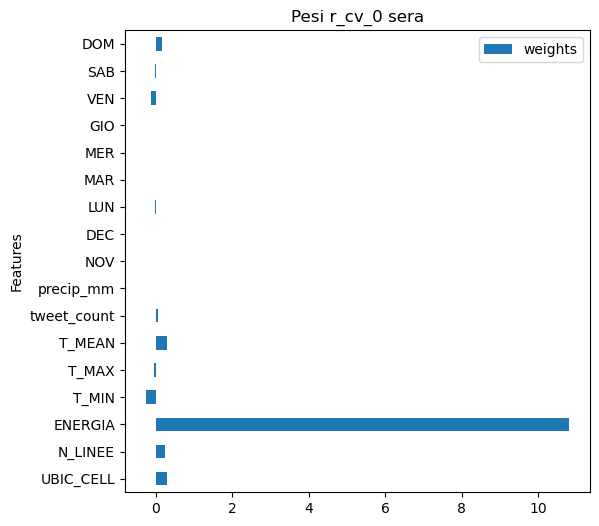

In [321]:
df_w = pd.DataFrame({'features':features, 'weights': r_cv_night_0.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv_0 sera')

Qualche osservazione. Come si poteva aspettare la feature più importante risulta proprio l'energia. Seguono il numero di linee per cella e il numero di ubicazione nella cella. Osserviamo come i giorni feriali della settimana incidano poco sul modello, mentre i giorni festivi risultano più impattanti. Interessante notare come il peso di venerdì siano negativo: questo succede perchè da venerdì in poi i consumi (soprattutto nelle aree ad alto consumo energetico) si riducono. Anche la temperatura massima e quella minima raggiunte nell'arco della giornata non incidono molto, ma piuttosto la temperatura media che tiene conto di etrambe. Sicuramente poco importante è che mese stiamo analizzando. Pure le precipitazioni influenzano poco o nulla il modello, così come il numero di tweet. Possiamo quindi provare a tenere solamente le features più importanti.

Proviamo ora ad usare LassoCV: il regolarizzatore Lasso usa la norma L1 che mette in risalto le features più importanti e annulla quelle meno importanti.

In [324]:
scaler = StandardScaler()

In [325]:
array= np.logspace(-4,2,num=50)

In [326]:
r_lasso_day_1 = LassoCV(alphas=array, cv=10)
r_lasso_night_1 = LassoCV(alphas=array, cv=10)

In [327]:
r_lasso_day_1.fit(X_train_day, Y_train_day)
r_lasso_night_1.fit(X_train_night, Y_train_night)
print('LassoCV giorno:')
print_errors(r_lasso_day_1,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('LassoCV notte:')
print_errors(r_lasso_night_1,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

LassoCV giorno:
r^2_train 0.9162866076443144 - r^2_valid 0.93467458236458
Err_train 10.896651992358223 - Err_valid 8.94328010284532
LassoCV notte:
r^2_train 0.9408479426560061 - r^2_valid 0.9434063495816437
Err_train 5.216924622683712 - Err_valid 5.1482293859649895


Il modello è cambiato ma in modo impercettibile.

In [329]:
coef = pd.Series(r_lasso_day_1.coef_, index=features)
coef_nonzero = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print("Features selezionate dal Lasso:")
print(coef_nonzero)

print("\nNumero di features tenute:", coef_nonzero.size)
print("Numero di features eliminate:", (coef == 0).sum())

Features selezionate dal Lasso:
ENERGIA      10.500847
N_LINEE       0.480090
UBIC_CELL     0.429876
DOM           0.428322
VEN          -0.228198
SAB          -0.123518
T_MAX         0.106544
T_MIN        -0.039543
MER           0.033082
precip_mm     0.014475
GIO           0.010030
dtype: float64

Numero di features tenute: 11
Numero di features eliminate: 6


Il lasso ci da la conferma che alcune features contano molto poco rispetto ad altre che sono state eliminate dalla funzione LassoCV. Notiamo però che alcune features che LassoCV elimina sono più rilevanti nel RidgeCV. Ricordiamoci però che alcune features sono correlate tra loro e quindi il LassoCV potrebbe decidere di mandare a zero alcune tra esse in modo arbitrario.

Proviamo ad eliminare le features inutili e a tenere quelle più importanti utilizzando l'analisi fatta in precedenza cobn Ridge e Lasso.

In [332]:
features_drop = [
    'cellId',
    'fascia_giorno',
    'tweet_count',
    'precip_mm',
    'NOV',
    'DEC',
    'LU',
    'MA',
    'ME',
    'GI',
    'temp_mean',
    'day',
]

In [333]:
features_1 = {
 'UBIC_CELL':'UBIC_CELL',
 'n_linee':'N_LINEE',
 'energy':'ENERGIA',
 'temp_max':'T_MAX',
 'temp_min':'T_MIN',
 'VE':'VEN',
 'SA':'SAB',
 'DO':'DOM' ,
 'TargetReg':'Target' 
}

In [334]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_1,df_night_1) = pre_processing(df_day, df_night, features_drop, features_1)

In [335]:
features = tuple(X_test_day.columns)

In [336]:
features

('UBIC_CELL', 'N_LINEE', 'ENERGIA', 'T_MIN', 'T_MAX', 'VEN', 'SAB', 'DOM')

In [337]:
scaler.fit(df_day_1)
X_train_day=scaler.transform(X_train_day)
X_valid_day=scaler.transform(X_valid_day)
X_test_day=scaler.transform(X_test_day)

X_train_night=scaler.transform(X_train_night)
X_valid_night=scaler.transform(X_valid_night)
X_test_night=scaler.transform(X_test_night)

Rifacciamo il RidgeCV

In [339]:
r_cv_day_1 = RidgeCV(alphas= array, cv=10)
r_cv_night_1 = RidgeCV(alphas= array, cv=10)

In [340]:
r_cv_day_1.fit(X_train_day, Y_train_day)
r_cv_night_1.fit(X_train_night, Y_train_night)
print('RidgeCV_0 giorno:')
print_errors(r_cv_day_1,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV_0 notte:')
print_errors(r_cv_night_1,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV_0 giorno:
r^2_train 0.9162744907066412 - r^2_valid 0.934644890099412
Err_train 10.898229207775273 - Err_valid 8.947345078683176
RidgeCV_0 notte:
r^2_train 0.9408388609926204 - r^2_valid 0.9434090601002542
Err_train 5.217725581356314 - Err_valid 5.147982814636606


Text(0.5, 1.0, 'Pesi r_cv_1 giorno')

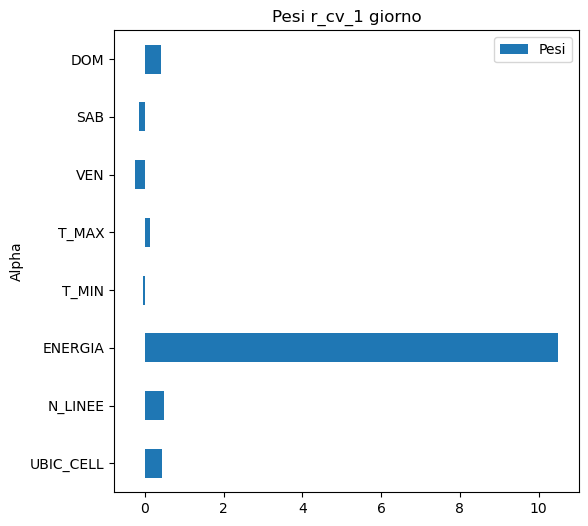

In [341]:
df_w = pd.DataFrame({'features':features, 'Pesi': r_cv_day_1.coef_})
ax = df_w.plot.barh(y='Pesi', x='features', figsize=(6, 6))
ax.set_ylabel('Alpha')
ax.set_title('Pesi r_cv_1 giorno')

Text(0.5, 1.0, 'Pesi r_cv_1 notte')

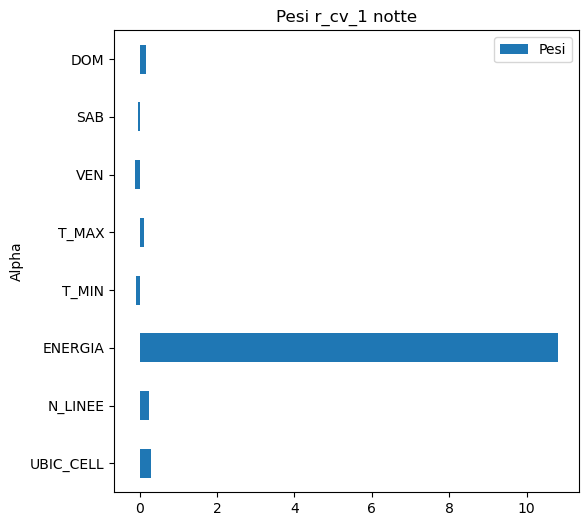

In [342]:
df_w = pd.DataFrame({'features':features, 'Pesi': r_cv_night_1.coef_})
ax = df_w.plot.barh(y='Pesi', x='features', figsize=(6, 6))
ax.set_ylabel('Alpha')
ax.set_title('Pesi r_cv_1 notte')

Il modello è praticamente rimasto invariato, però riducendo il numero di features il modello è meno complicato e più leggero. Decidiamo di tenere questo allora.

Cerchiamo adesso il modello migliore considerando anche modelli polinomiali di grado superiore. Per farlo utilizziamo una grid search rispetto al regolarizzatore Ridge: utilizziamo l'ultimo modello con un numero minore di features per rendere l'algoritmo meno pesante computazionalmente

In [345]:
param_grid = {'model': [Ridge()],
              'model__alpha': [0.01,0.1,1.0], 
              'polynomialfeatures__degree': [1, 2, 3, 4]}  # Gradi del polinomio

# Creo una pipeline con le features polinomiali
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('model', Ridge())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_day, Y_train_day)
best_model_day = grid_search.best_estimator_
grid_search.fit(X_train_night, Y_train_night)
best_model_night = grid_search.best_estimator_
print('Modello migliore giorno:')
print_errors(best_model_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello migliore giorno:
r^2_train 0.9564803252371472 - r^2_valid 0.955191161753202
Err_train 5.664789555971366 - Err_valid 6.1344880144619225
Modello migliore notte:
r^2_train 0.9525594757299786 - r^2_valid 0.9469935223371395
Err_train 4.184024196115782 - Err_valid 4.821910301476552


Il modello è migliorato molto. Di seguito riportiamo i parametri ottenuti dalla grid search:

In [347]:
best_model_day.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures(degree=4)),
  ('model', Ridge())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'model': Ridge(),
 'polynomialfeatures__degree': 4,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'model__alpha': 1.0,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.0001}

Uniamo i dataset train e valid e rifacciamo il train per allenare il modello su un numero di dati maggiore, confrontando infine le nostre stime di E_out e E_in usando l'insieme di test

In [349]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [350]:
best_model_day.fit(X_final_day, Y_final_day)
best_model_night.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(best_model_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:
r^2_train 0.9571332786380317 - r^2_valid 0.9579997833188827
Err_train 5.652018350300078 - Err_valid 5.796281893982576
Modello migliore notte:
r^2_train 0.9521723784519539 - r^2_valid 0.958279424100758
Err_train 4.2513550117099665 - Err_valid 3.7384857232183686


Osserviamo che il modello è migliorato ulteriormente. Possiamo provare a visualizzare i risultati ottenuti sino a questo punto andando a selezionare diverse celle in base alla loro energia : alto, basso consumo e consumo negativo. In questo modo mettiamo in mostra dove il nostro modello è più forte e dove può migliorare.

In [352]:
X_day=df_day_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',               
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [353]:
X_day

,UBIC_CELL,N_LINEE,ENERGIA,T_MIN,T_MAX,VEN,SAB,DOM
0,4,1,0.072206,9.3,18.9,1,0,0
2,4,1,0.128870,12.3,15.9,0,1,0
4,4,1,0.102435,12.2,19.2,0,0,1
6,4,1,0.178414,8.6,10.9,0,0,0
8,4,1,0.108142,8.2,16.6,0,0,0
...,...,...,...,...,...,...,...,...
237912,3,1,0.329076,0.1,0.8,0,0,0
237914,3,1,0.298320,-2.9,2.0,1,0,0
237916,3,1,0.317222,-3.7,2.8,0,1,0
237918,3,1,0.331215,-0.3,2.2,0,0,1


In [354]:
df_day_copy   = df_day.copy()
df_night_copy = df_night.copy()

df_day_copy.loc[:, 'PRED']   = best_model_day.predict(scaler.transform(X_day))
df_night_copy.loc[:, 'PRED'] = best_model_night.predict(scaler.transform(X_night))

Definiamo una funzione che ci ritorni una cella randomica tra quelle che hanno una energia tra due valori. Così possiamo confrontare il nostro modello 
casualmente.

In [356]:
def find_cell(massimo,minimo,df):
        """
        funzione che trova in modo randomico una cella che ha consumi medi tra un valore di massimo e uno di minimo nell'arco dei due mesi
        funzione che prende in INPUT
        -> massimo: valore massimo dei consumi medi
        -> minimo: valore minimo dei consumi medi
        -> df: dataframe che si sta analizzando
        OUTPUT
        -> rc: cellId di una cella randomica tra quelle che rispetta i requisti richiesti
        """
        mean = df.groupby('cellId')['energy'].mean()
        gc = mean[(massimo >mean ) & (mean > minimo)].index.tolist()
    
        rc = np.random.choice(gc) #scelta randomica
        return(rc)

Scegliamo quali consumi andare a visualizzare 

In [358]:
ID_alto_consumo=find_cell(500,70,df_day_copy)
ID_basso_consumo=find_cell(1,0,df_day_copy)
ID_neg_consumo=find_cell(-10,-40,df_day_copy)

Ora verifichiamo la bontà del nostro modello. Facciamo prima una panoramica generale e poi ci soffermiamo sui giorni della settimana. Definiamo una funzione che plotti i dati

In [360]:
def plott_data(df,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo):

    """
    funzione che plotta i dati relativi al target energetico e la previsione del modello
    funzione che prende in INPUT
    -> df: dataframe considerato di cui plottare i dati
    -> ID_alto/basso/neg_consumo: cellId delle celle di cui vogliamo plottare i dati
    OUTPUT
    -> mse1: stnd deviation delle predizioni rispetto al targe di cella ad alto consumo
    -> mse2:  stnd deviation delle predizioni rispetto al targe di cella a basso consumo
    -> mse3:  stnd deviation delle predizioni rispetto al targe di cella a consumo negativo
    """       
    
    fig = plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2,1])
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    ax3 = fig.add_subplot(gs[1,:])   # sotto, che occupa due colonne
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    # Terzo subplot
    df_graph= df[(df["cellId"] == ID_neg_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax3.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax3.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax3.set_xlabel('Giorno')
    ax3.set_ylabel('Potenza media')
    ax3.set_title('Zona a consumo negativo')
    ax3.legend()
    
    mse3 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    return (mse1,mse2,mse3)


Presentiamo i dati reali rispetto le predizioni del nostro modello.

Dati diurni:

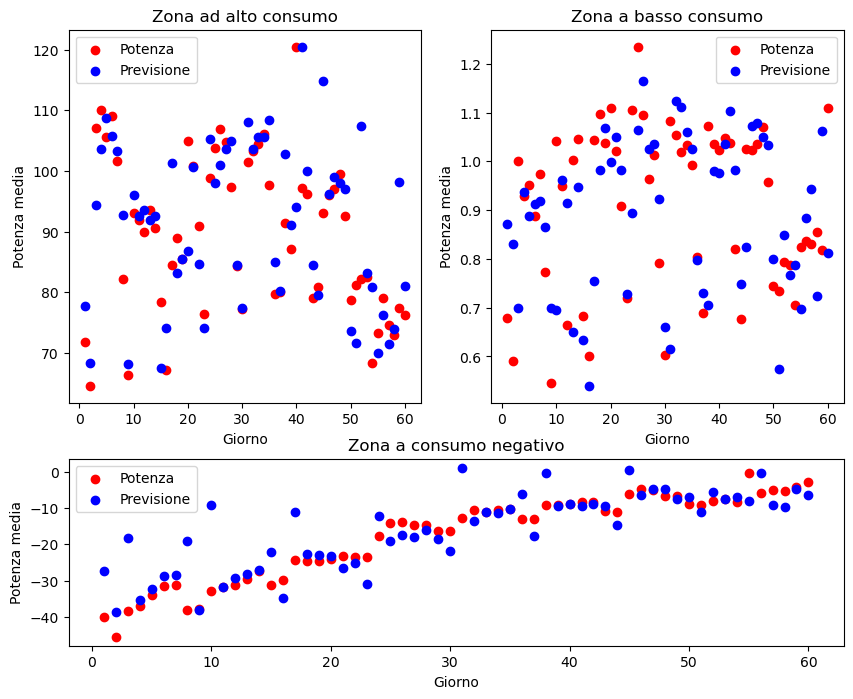

In [363]:
(mse1,mse2,mse3)=plott_data(df_day_copy,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [364]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 9.091702487573837 
 Deviazione standard 2: 0.15629778028956337 
 Deviazione standard 3: 6.612432664446361


Dati serali:

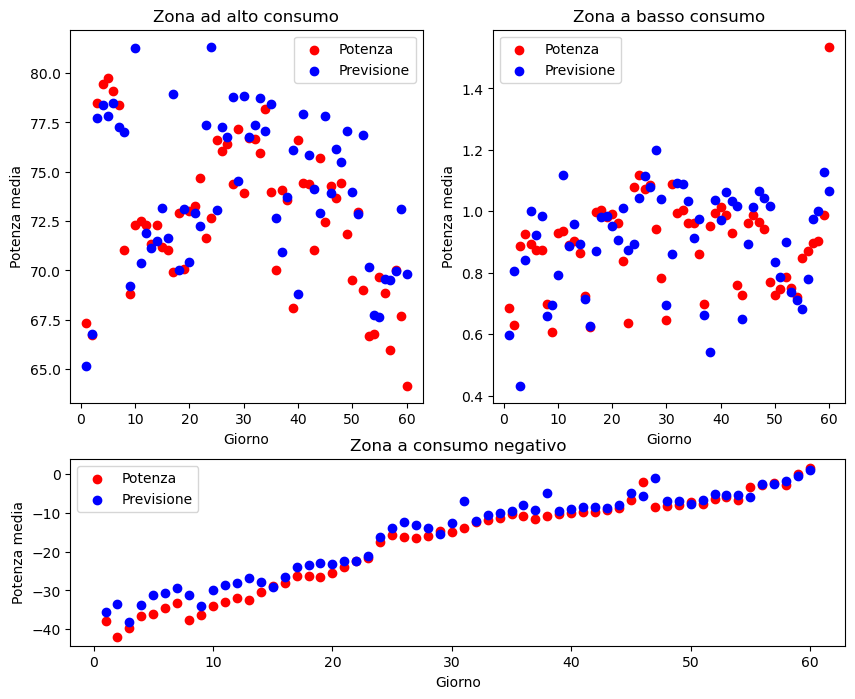

In [366]:
(mse1,mse2,mse3)=plott_data(df_night_copy,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [367]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 3.7911200993191145 
 Deviazione standard 2: 0.15196032821076683 
 Deviazione standard 3: 3.024000976520278


Proviamo ora ad analizzare i dati confrontando i consumi energetici reali con quelli previsti dal modello in base al giorno della settimana.

In [369]:
def plot_cell_energy(df_0,df_1,cell_id):
    """
    funzione che plotta i dati relativi al target energetico e la previsione del modello raggruppandoli in giorni della settimana, facendone la media
    e la deviazione standard( barra di incertezza nera presente nel plot)
    funzione che prende in INPUT
    -> df_0: dataframe fascia giorno di cui plottare i dati
    -> df_1: dataframe fascia notte di cui plottare i dati
    """
    # filtro la cella richiesta
    df_cell_0 = df_0[df_0["cellId"] == cell_id].copy()
    df_cell_1 = df_1[df_1["cellId"] == cell_id].copy()

    giorni = ["LU", "MA", "ME", "GI", "VE", "SA", "DO"]
 
    df_cell_0.loc[:, "day_of_w"] = df_cell_0[giorni].idxmax(axis=1)
  

    df_cell_0.loc[:, "day_of_w"] = pd.Categorical(df_cell_0["day_of_w"], 
                                            categories=giorni, 
                                            ordered=True)

    # trasformo in formato lungo
    df_melt_0 = df_cell_0.melt(
        id_vars=["day_of_w"], 
        value_vars=["TargetReg", "PRED"], 
        var_name="Tipo", value_name="Energia"
    )

    
    df_cell_1.loc[:, "day_of_w"] = df_cell_1[giorni].idxmax(axis=1)
  

    df_cell_1.loc[:, "day_of_w"] = pd.Categorical(df_cell_1["day_of_w"], 
                                            categories=giorni, 
                                            ordered=True)

    # trasformo in formato lungo
    df_melt_1 = df_cell_1.melt(
        id_vars=["day_of_w"], 
        value_vars=["TargetReg", "PRED"], 
        var_name="Tipo", value_name="Energia"
    )
    
    # plot a barre affiancate
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

    sns.barplot(data=df_melt_0, x="day_of_w", y="Energia", hue="Tipo", dodge=True,errorbar="sd",ax=axs[0])
    axs[0].set_title(f"Confronto energia attuale vs previsione giorno- CellId {cell_id}")
    axs[0].set_xlabel("Giorno della settimana")
    axs[0].set_ylabel("Energia")


    sns.barplot(data=df_melt_1, x="day_of_w", y="Energia", hue="Tipo", dodge=True,errorbar="sd",ax=axs[1])
    axs[1].set_title(f"Confronto energia attuale vs previsione notte - CellId {cell_id}")
    axs[1].set_xlabel("Giorno della settimana")
    axs[1].set_ylabel("Energia")


    plt.tight_layout()
    plt.show()


Cella ad alto consumo:

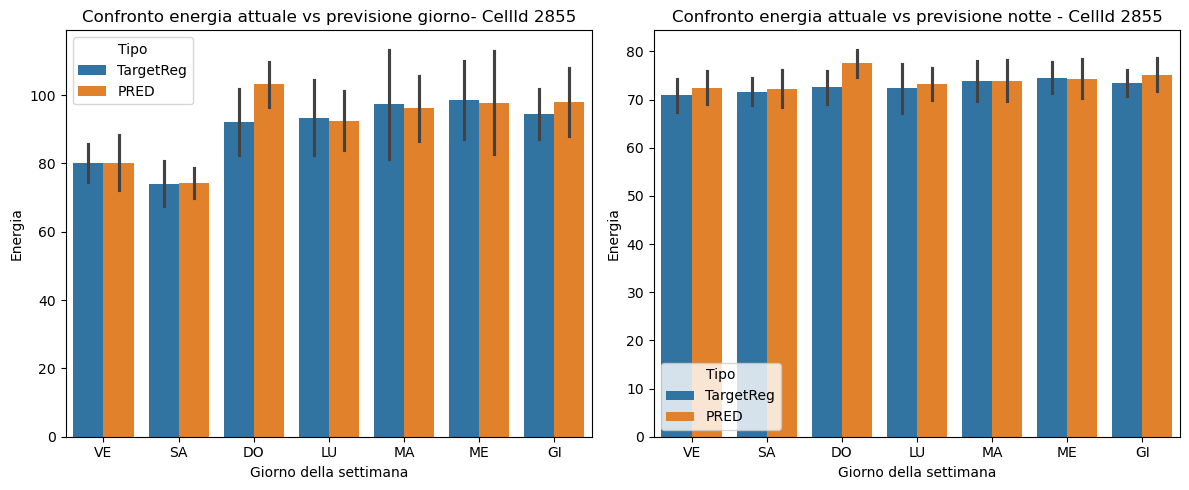

In [371]:
plot_cell_energy(df_day_copy,df_night_copy,ID_alto_consumo)

Cella a basso consumo:

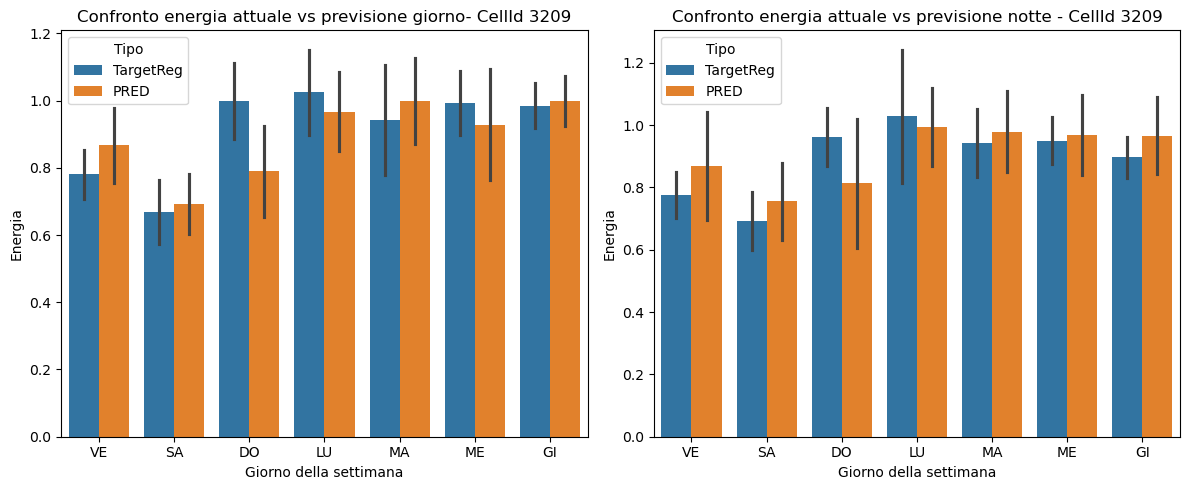

In [373]:
plot_cell_energy(df_day_copy,df_night_copy,ID_basso_consumo)

Cella a consumo negativo:

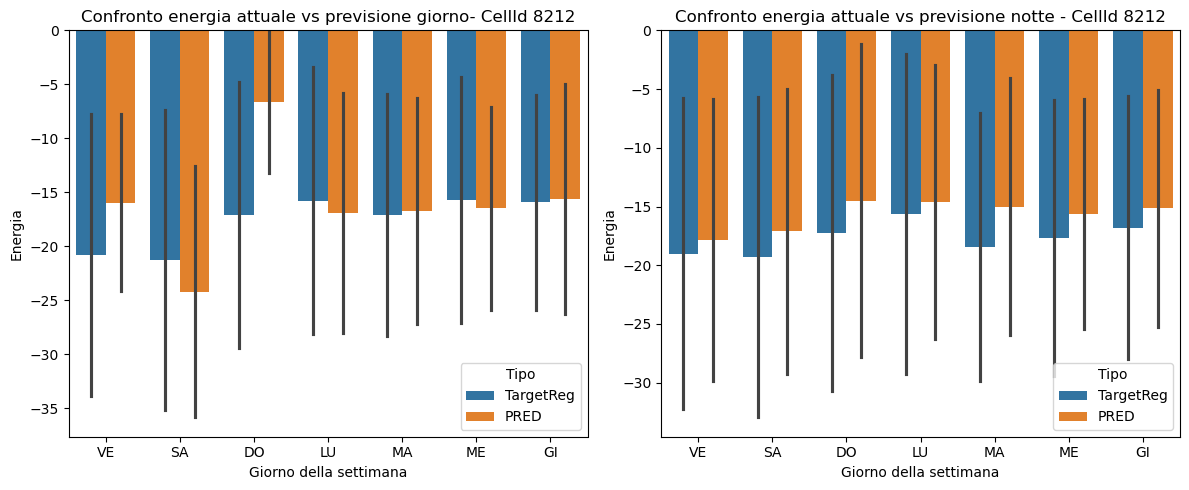

In [375]:
plot_cell_energy(df_day_copy,df_night_copy,ID_neg_consumo)

Osserviamo che il modello presenta qualche lacuna. Per quanto riguarda la cella ad alto consumo il modello tende ad avvicinarsi al target abbastanza bene. Per la cella a basso consumo osserviamo che la varianza è estremamente elevata: quando andiamo ad analizzare celle, probabilmente lontane da centri abitati, queste hanno un consumo energetico prossimo allo zero e il modello fa fatica a prevedere il dato del gionro successivo con precisione perchè non ha molte atre feature a disposizione. Anche per quanto riguarda il consumo negativo il modello non riesce a prevedere il dato bene come per la cella ad alto consumo, ma da comunque una buona stima. Pure qui la varianza è molto alta ma questo rispecchia i dati originali: si vede chiaramente nel plot dei consumi che con l'avanzare dei giorni ci avviciniamo all'inverno, con sempre meno sole, e con un trend in salita per i consumi. Per quanto riguarda le previsioni rispetto ai giorni della settimana osserviamo che....  . Si conferma il fatto già citato che il modello serale è migliore rispetto a quello diurno.

## FASCIA ORARIA RESTRITTIVA 

In questa parte, carichiamo i dataset relativi alla fascia oraria 9-12 ("fascia giorno" = 1) e fascia oraria 18-21  ("fascia giorno" = 0). L'obiettivo è verificare se i modelli precedentemente creati riescono a fare previsioni accurate per le potenze in questa fascia, oppure se è necessario creare un nuovo modello specifico per predire i dati di questa fascia oraria.

In [379]:
df_reg_rist=pd.read_csv(r"D:\03_TURO\UNI\TRIENNALE\III_ANNO\Data_Science\Project\Data_reg\trentino_dataset_reg_ristretto.csv")
df_day_rist=df_reg_rist[df_reg_rist["fascia_giorno"]==1]
df_night_rist=df_reg_rist[df_reg_rist["fascia_giorno"]==0]


Usiamo il modello con meno features ricavato nella parte precedente

In [381]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_1,df_night_1) = pre_processing(df_day, df_night, features_drop, features_1)

In [382]:
X_train_day=scaler.transform(X_train_day)
X_valid_day=scaler.transform(X_valid_day)
X_test_day=scaler.transform(X_test_day)

X_train_night=scaler.transform(X_train_night)
X_valid_night=scaler.transform(X_valid_night)
X_test_night=scaler.transform(X_test_night)

In [383]:
print('Modello best_model_day su fascia restrittiva:')
print_errors(best_model_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello best_model_night su fascia restrittiva:')
print_errors(best_model_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello best_model_day su fascia restrittiva:
r^2_train 0.9558108877092948 - r^2_valid 0.960904656950742
Err_train 5.751927677678814 - Err_valid 5.352290368163874
Modello best_model_night su fascia restrittiva:
r^2_train 0.9517692537657038 - r^2_valid 0.9533434699847877
Err_train 4.253717941488611 - Err_valid 4.244266222374034


Entrambi i modelli restituiscono risultati simili a quelli ottenuti in precedenza. E' interessante notare che il modello relativo alla fascia giornaliera mostra errori Err_valid leggermente migliori. Questo suggerisce che è possibile effettuare previsioni sulla potenza del giorno successivo utilizzando una fascia oraria più ristretta.

## RANDOM FOREST

A questo punto proviamo ad utilizzare una random forest: si tratta di un modello di previsione molto più pesante da un punto di vista computazionale. Quello che abbiamo fatto è stato prima testare l'efficienza del modello al variare dei parametri del regressore RandomForestRegressor(). I parametri qui usati sono quelli che abbiamo deciso di utilizzare dopo numerosi tentativi, cercando un trade tra bontà del modello e tempo di computazione. Anche qui utilizziamo solo le 8 features selezionate in precedenza, per non gravare sulla complessità e sul tempo di esecuzione. 

In [387]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_1,df_night_1) = pre_processing(df_day, df_night, features_drop, features_1)

In [388]:
rnd_for_day=RandomForestRegressor( 
    n_estimators=500,
    criterion='squared_error',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features=1.0, 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None,
    verbose=2,
    warm_start=False, 
    ccp_alpha=0.0,
    max_samples=0.8, 
    monotonic_cst=None)

rnd_for_night=RandomForestRegressor( 
   n_estimators=500,
    criterion='squared_error',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features=1.0, 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None,
    verbose=2,
    warm_start=False, 
    ccp_alpha=0.0,
    max_samples=0.6, 
    monotonic_cst=None)


Come in precedenza abbiamo prima verificato che il modello fosse buono trainandolo sull'insieme di training e poi verificandolo sull'insieme di validazione. In seguito abbiamo riallenato il modello sull'insieme di training unito a quello di validazione. Qui riportiamo solo il secondo momento, dato che la funzione .fit su dataframe di questi dimensioni richiede qualche minuto per terminare e eseguirla due volte  rallenterebbe il notebook.

In [390]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [391]:
X_day=df_day_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',               
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [392]:
rnd_for_day.fit(X_final_day, Y_final_day)
rnd_for_night.fit(X_final_night, Y_final_night)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   14.5s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   58.2s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:  2.2min


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.5s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   47.4s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:  1.8min


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


RandomForestRegressor(max_depth=30, max_samples=0.6, min_samples_leaf=5,
                      n_estimators=500, oob_score=True, verbose=2)

In [393]:
print('Modello migliore giorno:')
print_errors(rnd_for_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(rnd_for_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.4s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.3s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9744425120204157 - r^2_valid 0.9634570966590882
Err_train 3.369779317350419 - Err_valid 5.043139910364093
Modello migliore notte:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.1s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.4s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9659138942917295 - r^2_valid 0.9575872867722591
Err_train 3.0298838127870864 - Err_valid 3.8005065718123263


Vediamo che il modello è migliorato ancora abbassando l'errore. A questo punto plottiamo i dati e confrontiamo le previsioni del modello con i valori target:

In [395]:
df_day_copy_1   = df_day.copy()
df_night_copy_1 = df_night.copy()

df_day_copy_1.loc[:, 'PRED']   = rnd_for_day.predict((X_day))
df_night_copy_1.loc[:, 'PRED'] = rnd_for_night.predict((X_night))

C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.6s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    5.9s


Dati diurni:


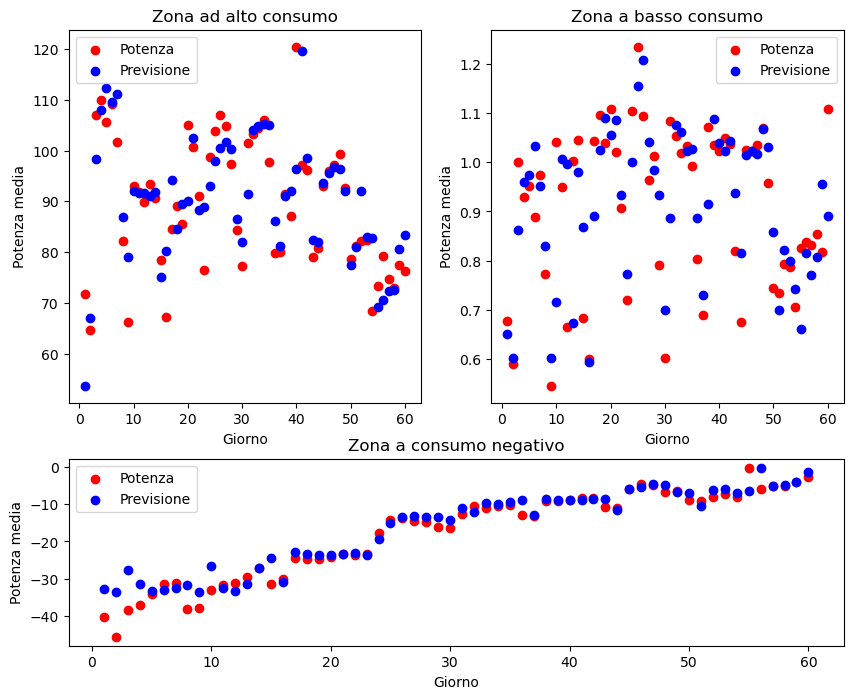

In [397]:
(mse1,mse2,mse3)=plott_data(df_day_copy_1,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [398]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 7.545056942655455 
 Deviazione standard 2: 0.11239660370399814 
 Deviazione standard 3: 3.306082741876731


Dari serali:

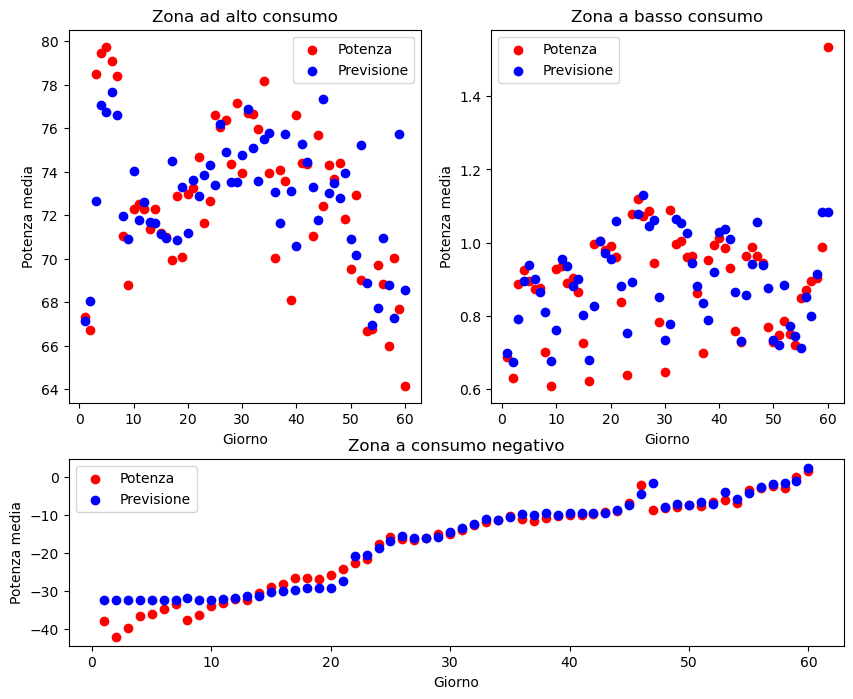

In [400]:
(mse1,mse2,mse3)=plott_data(df_night_copy_1,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [401]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 2.7569570686700193 
 Deviazione standard 2: 0.10499648333501074 
 Deviazione standard 3: 2.6261286989044166


Cella ad alto consumo:

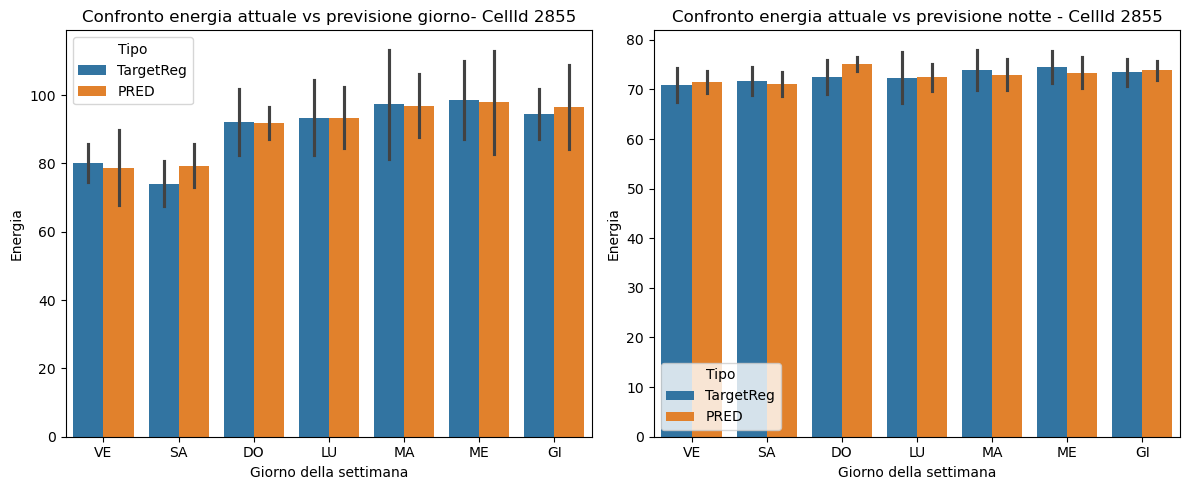

In [403]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_alto_consumo)

Cella a basso consumo:

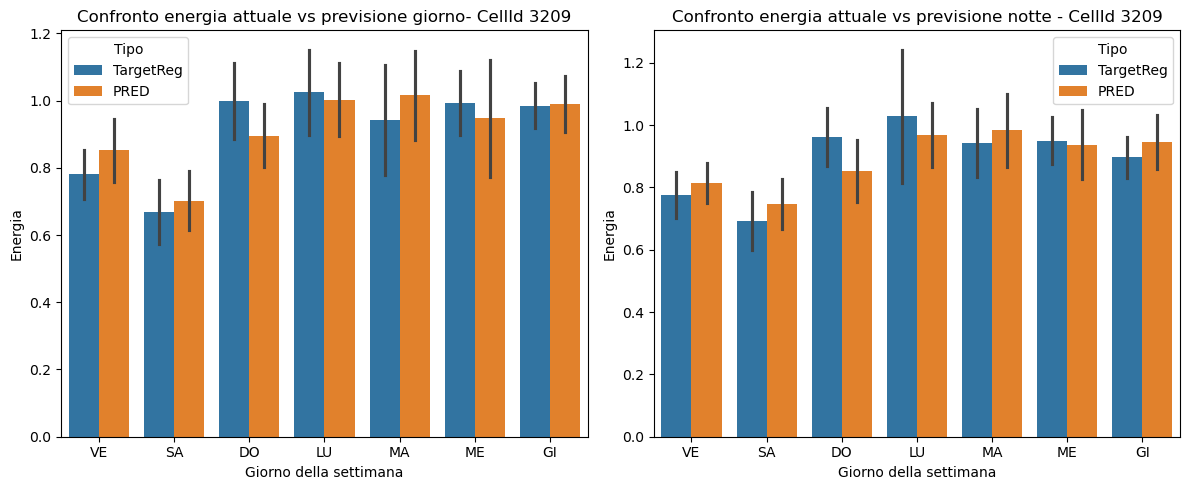

In [405]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_basso_consumo)

Cella a consumo negativo:

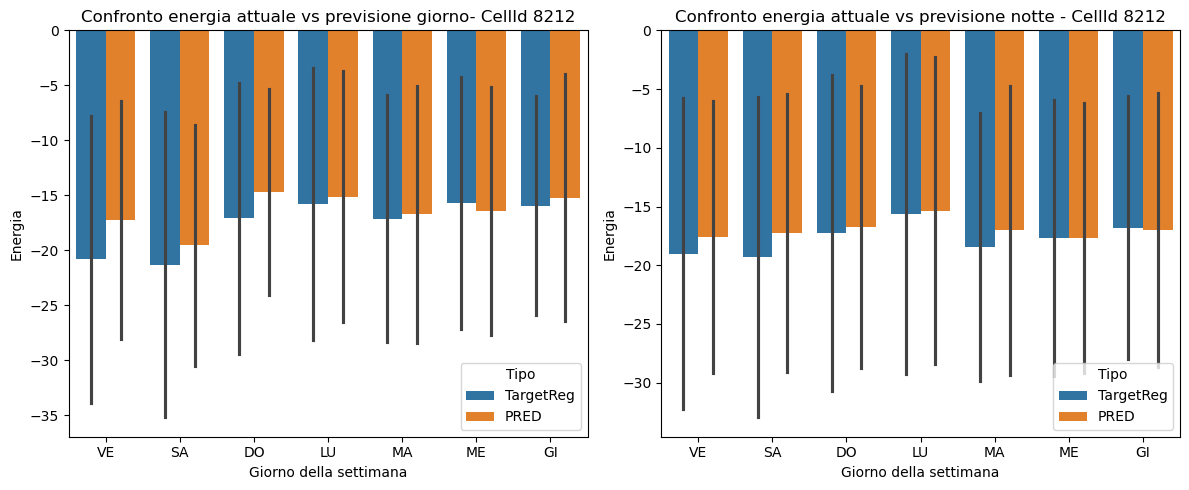

In [407]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_neg_consumo)

Il modello con le random forest è cambiato: osserviamo come la varianza a bassi consumi è stata notevolmente ridotta e in generale per la cella a basso consumo e a consumo negativo le previsioni sono migliorate, diventando molto più stabili, anche se resta poco accurato quando i consumi sono molto bassi (ad inizio Novembre). Ciò è andato leggermente a discapito delle previsioni per la cella ad alto consumo. Resta il fatto che ora il modello è più robusto per qualunque cella del dataframe.

Salviamo il modello delle random forest, sia per la notte che per il giorno: 

In [410]:
from joblib import dump, load

In [411]:
models = {'Trentino_consumi_day':{'filename':'Trentino_consumi_day.pkl','value':rnd_for_day},
          'Trentino_consumi_night':{'filename':'Trentino_consumi_night.pkl','value':rnd_for_night}}
          
dump(models['Trentino_consumi_day']['value'], models['Trentino_consumi_day']['filename'])
dump(models['Trentino_consumi_night']['value'], models['Trentino_consumi_night']['filename'])

pklfiles = [dump(**mod) for mod in models.values()]

# CONSUMI A TRENTO 

Carichiamo adesso i dati riguardanti solamente il comune di Trento. In questa zona ci aspettiamo che i consumi siano piuttosto alti perchè stiamo considerando aree densamente abitate e zone industriali. Decidiamo quindi di utilizzare un modello diverso da quello dell'intera provincia di Trento.

In [414]:
df_reg_tn=pd.read_csv(r"D:\03_TURO\UNI\TRIENNALE\III_ANNO\Data_Science\Project\Data_reg\trentino_dataset_reg_trento.csv")

df_day_tn=df_reg_tn[df_reg_tn["fascia_giorno"]==1]
df_night_tn=df_reg_tn[df_reg_tn["fascia_giorno"]==0]

In [415]:
df_day_tn

,cellId,day,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,...,NOV,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg
0,4030,1,1,10,1,0.343408,11.9,17.5,15.665909,0,...,1,0,0,0,0,0,1,0,0,0.355429
2,4030,2,1,10,1,0.355429,11.0,16.0,13.836364,0,...,1,0,0,0,0,0,0,1,0,0.321361
4,4030,3,1,10,1,0.321361,13.9,18.8,15.772727,0,...,1,0,0,0,0,0,0,0,1,0.514038
6,4030,4,1,10,1,0.514038,8.5,10.4,9.340909,0,...,1,0,1,0,0,0,0,0,0,0.459964
8,4030,5,1,10,1,0.459964,9.0,15.3,12.125000,0,...,1,0,0,1,0,0,0,0,0,0.453601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17628,6256,26,1,6,2,0.126607,1.1,3.3,1.809091,0,...,0,1,0,0,0,1,0,0,0,0.111266
17630,6256,27,1,6,2,0.111266,2.7,9.2,5.579545,0,...,0,1,0,0,0,0,1,0,0,0.115073
17632,6256,28,1,6,2,0.115073,0.4,5.7,2.975000,0,...,0,1,0,0,0,0,0,1,0,0.115692
17634,6256,29,1,6,2,0.115692,3.1,4.6,3.843182,0,...,0,1,0,0,0,0,0,0,1,0.108612


Come fatto in precedenza dividiamo il df in insiemi di training, validazione e test.

In [417]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_tn_0,df_night_tn_0) = pre_processing(df_day_tn, df_night_tn, features_drop, features_1)


Non essendoci celle a potenza negativa a Trento ci concentriamo solo su quelle ad alto consumo e a basso consumo

In [419]:
ID_alto_consumo=find_cell(300,50,df_day_tn)
ID_basso_consumo=find_cell(50,0,df_day_tn)

Come già spiegato a proposito per la provincia di Trento, abbiamo eseguito più volte training e validazione per vedere se effettivamente 
il modello fosse buono abbastanza. Qui riportiamo solo la parte dove alleniamo il modello su i dati di training e validazione uniti.

In [421]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [422]:
X_day=df_day_tn_0[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_tn_0[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [423]:
rnd_for_day.fit(X_final_day, Y_final_day)
rnd_for_night.fit(X_final_night, Y_final_night)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s


building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    5.6s


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.1s


building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    2.6s


building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500


RandomForestRegressor(max_depth=30, max_samples=0.6, min_samples_leaf=5,
                      n_estimators=500, oob_score=True, verbose=2)

In [424]:
print('Modello migliore giorno:')
print_errors(rnd_for_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(rnd_for_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9893305061474889 - r^2_valid 0.9770115296343896
Err_train 7.9479113416789655 - Err_valid 18.429423092990383
Modello migliore notte:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9932353095353974 - r^2_valid 0.9865955609478765
Err_train 2.9681602184684444 - Err_valid 6.453006180298158


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


Il modello è buono, anche se osserviamo errori di validazione un po' alti. A questo punto non ci rimane che verificare i consumi previsti e confrontarli con i corrispettivi target:

In [426]:
df_day_tn_copy_0   = df_day_tn.copy()
df_night_tn_copy_0 = df_night_tn.copy()

df_day_tn_copy_0.loc[:, 'PRED']   = rnd_for_day.predict((X_day))
df_night_tn_copy_0.loc[:, 'PRED'] = rnd_for_night.predict((X_night))

C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s


Dati diurni:

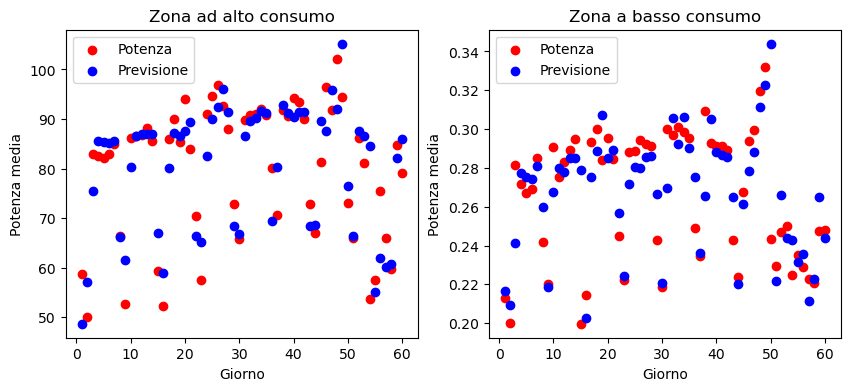

In [428]:
    df=df_day_tn_copy_0
    fig = plt.figure(figsize=(10,4))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))

In [429]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2)

Deviazione standard 1: 6.736187917173846 
 Deviazione standard 2: 0.02167689162719812


Dati serali:

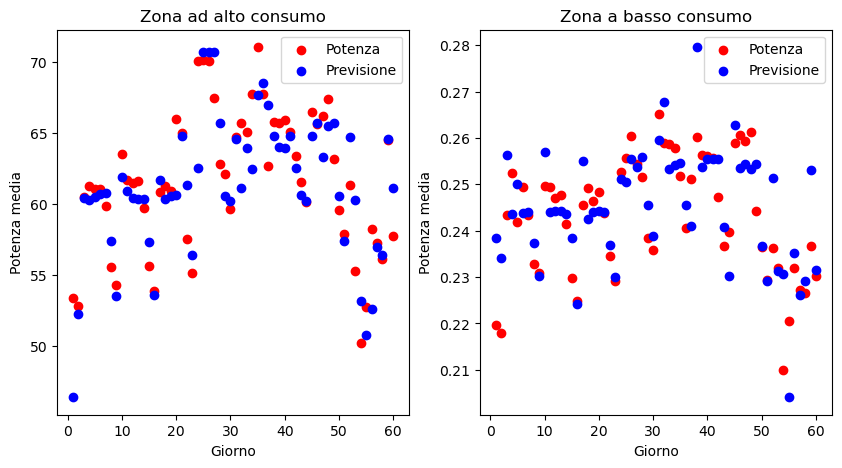

In [431]:
    df=df_night_tn_copy_0
    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))

In [432]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2)

Deviazione standard 1: 2.5620600795532447 
 Deviazione standard 2: 0.007925819177489909


Cella ad alto consumo:

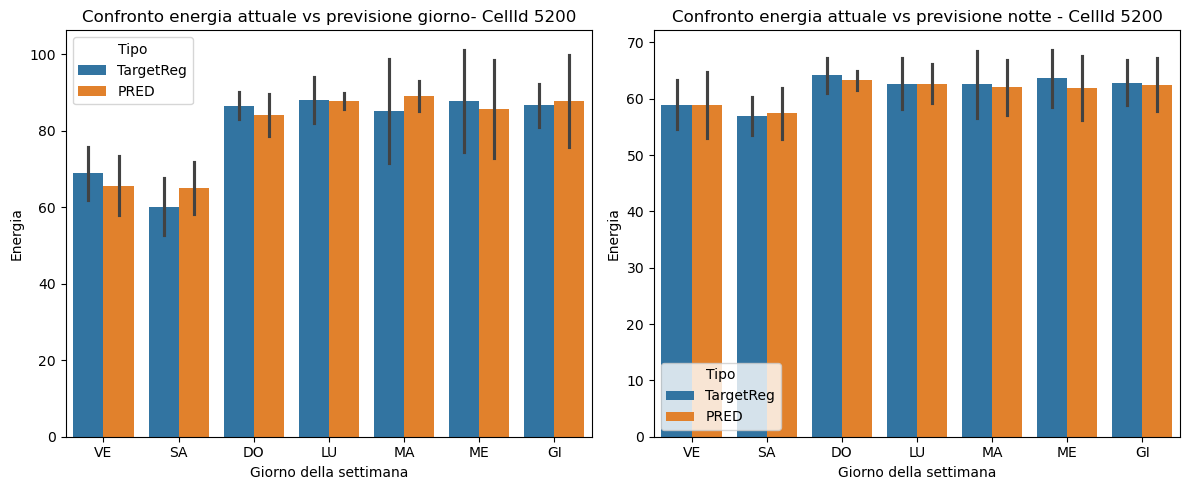

In [434]:
plot_cell_energy(df_day_tn_copy_0,df_night_tn_copy_0,ID_alto_consumo)

Cella a basso consumo:

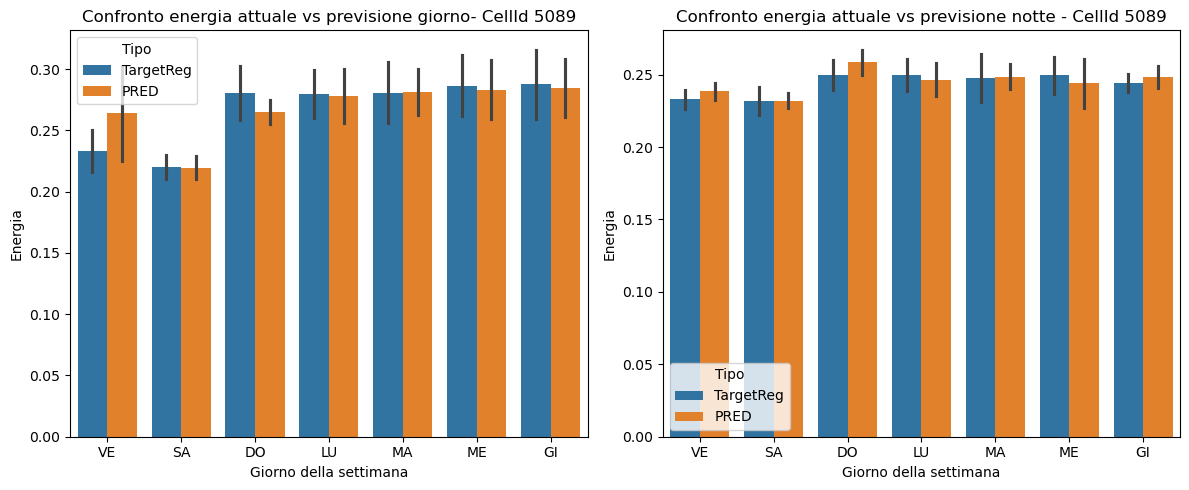

In [436]:
plot_cell_energy(df_day_tn_copy_0,df_night_tn_copy_0,ID_basso_consumo)

Come possiamo osservare il modello è in grado di prevedere abbastanza bene il target, sia per le celle ad alto consumo che per le celle a basso consumo. Questo modello si comporta meglio di quello relativo a tutta la provincia del Trentino: il motivo è che probabilmente in un'area così ristretta l'andamento dei consumi è più omogeneo e dunque prevedibile.

Per concludere salviamo anche questo modello:

In [439]:
models = {'Trento_consumi_day':{'filename':'Trento_consumi_day.pkl','value':rnd_for_day},
          'Trento_consumi_night':{'filename':'Trento_consumi_night.pkl','value':rnd_for_night}}
          
dump(models['Trento_consumi_day']['value'], models['Trento_consumi_day']['filename'])
dump(models['Trento_consumi_night']['value'], models['Trento_consumi_night']['filename'])

pklfiles = [dump(**mod) for mod in models.values()]